# 1. SETUP & DATA LOADING

In [1]:
# Impor semua library yang dibutuhkan di awal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Atur gaya visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Baca data dan atasi DtypeWarning dengan menentukan tipe data
# Ini lebih efisien secara memori daripada low_memory=False
try:
    df = pd.read_csv('wta.csv', dtype={'Odd_1': str})
except FileNotFoundError:
    print("File 'wta.csv' tidak ditemukan. Pastikan file sudah di-upload.")


# Buat salinan untuk proses cleaning agar data asli tetap aman
df_clean = df.copy()

print("Data berhasil dimuat.")
print(f"Jumlah baris: {df_clean.shape[0]}, Jumlah kolom: {df_clean.shape[1]}")

Data berhasil dimuat.
Jumlah baris: 42815, Jumlah kolom: 16


# **Data Understanding**

In [3]:
print("----------- Tipe Data Awal -----------")
print(df_clean.info())

----------- Tipe Data Awal -----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42815 entries, 0 to 42814
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tournament  42815 non-null  object 
 1   Date        42815 non-null  object 
 2   Court       42815 non-null  object 
 3   Surface     42815 non-null  object 
 4   Round       42815 non-null  object 
 5   Best of     42815 non-null  int64  
 6   Player_1    42815 non-null  object 
 7   Player_2    42815 non-null  object 
 8   Winner      42815 non-null  object 
 9   Rank_1      42815 non-null  int64  
 10  Rank_2      42815 non-null  int64  
 11  Pts_1       42815 non-null  int64  
 12  Pts_2       42815 non-null  int64  
 13  Odd_1       42815 non-null  object 
 14  Odd_2       42815 non-null  float64
 15  Score       42815 non-null  object 
dtypes: float64(1), int64(5), object(10)
memory usage: 5.2+ MB
None


In [4]:
print("\n----------- Statistik Deskriptif Awal (Numerik) -----------")
display(df_clean.describe())


----------- Statistik Deskriptif Awal (Numerik) -----------


,Best of,Rank_1,Rank_2,Pts_1,Pts_2,Odd_2
count,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000
mean,3.000047,76.436856,75.254350,1561.870349,1579.155086,2.512912
std,0.009666,94.283204,92.982248,1603.491003,1623.802444,2.082771
min,3.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000
25%,3.000000,24.000000,24.000000,629.000000,632.000000,1.400000
50%,3.000000,54.000000,53.000000,1025.000000,1032.000000,1.830000
75%,3.000000,96.000000,95.000000,1831.500000,1845.000000,2.750000
max,5.000000,1876.000000,1825.000000,13615.000000,13615.000000,51.000000


In [5]:
print("\n----------- Pengecekan Missing Values Awal -----------")
print(df_clean.isna().sum())


----------- Pengecekan Missing Values Awal -----------
Tournament    0
Date          0
Court         0
Surface       0
Round         0
Best of       0
Player_1      0
Player_2      0
Winner        0
Rank_1        0
Rank_2        0
Pts_1         0
Pts_2         0
Odd_1         0
Odd_2         0
Score         0
dtype: int64


In [6]:
print(f"\n----------- Jumlah Duplikat -----------")
print(f"Jumlah baris duplikat: {df_clean.duplicated().sum()}")


----------- Jumlah Duplikat -----------
Jumlah baris duplikat: 0


## Observasi dari Data Understanding:
Date dan Odd_1 perlu diubah tipe datanya.

Kolom Pts_1, Pts_2, dan Odd_2 memiliki nilai minimum -1 yang tidak logis dan perlu ditangani.

Tidak ada missing values yang terdeteksi di awal, namun ini bisa jadi karena data yang hilang direpresentasikan dengan -1 atau string kosong.

# **Data Cleaning & Preprocessing**

In [7]:
# --- 3.1. Koreksi Tipe Data ---
# Ubah 'Date' menjadi datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')

# Daftar kolom yang seharusnya numerik
numeric_cols = ['Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Best of']

# Ubah semua kolom numerik sekaligus menggunakan apply()
df_clean[numeric_cols] = df_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')

# --- 3.2. Penanganan Nilai Tidak Logis ---
# Ganti nilai -1 yang tidak logis dengan NaN (Not a Number) agar bisa diproses
# sebagai nilai kosong.
cols_with_neg_one = ['Pts_1', 'Pts_2', 'Odd_2']
df_clean[cols_with_neg_one] = df_clean[cols_with_neg_one].replace(-1, np.nan)

# --- 3.3. Penanganan Missing Values ---
# Hapus baris di mana tanggal atau pemain tidak valid (kritis untuk analisis)
critical_cols = ['Date', 'Player_1', 'Player_2', 'Winner', 'Surface']
df_clean.dropna(subset=critical_cols, inplace=True)

# Imputasi (isi nilai kosong) untuk kolom lain.
# Untuk Pts dan Rank, kita bisa drop karena sulit diimputasi dengan akurat.
df_clean.dropna(subset=['Rank_1', 'Rank_2', 'Pts_1', 'Pts_2'], inplace=True)

# Untuk Odds, imputasi dengan median adalah strategi yang baik.
for col in ['Odd_1', 'Odd_2']:
    median_val = df_clean[col].median()
    df_clean[col].fillna(median_val, inplace=True)

# --- 3.4. Penanganan Outliers ---
# Winsorization: Batasi nilai ekstrem pada persentil 1 dan 99
# Ini lebih sederhana dan efektif daripada kombinasi IQR + clip
for col in ['Odd_1', 'Odd_2', 'Pts_1', 'Pts_2', 'Rank_1', 'Rank_2']:
    low = df_clean[col].quantile(0.01)
    high = df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(lower=low, upper=high)

# --- 3.5. Standarisasi Tipe Data Final ---
# Optimalkan memori dengan mengubah object menjadi category
for col in df_clean.select_dtypes(include='object').columns:
    df_clean[col] = df_clean[col].astype('category')

# Reset index setelah drop baris
df_clean.reset_index(drop=True, inplace=True)

print("----------- Data Cleaning Selesai -----------")
print(f"Jumlah baris setelah cleaning: {df_clean.shape[0]}")
print("\n----------- Info Tipe Data Final -----------")
print(df_clean.info())

----------- Data Cleaning Selesai -----------
Jumlah baris setelah cleaning: 42811

----------- Info Tipe Data Final -----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42811 entries, 0 to 42810
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tournament  42811 non-null  category      
 1   Date        42811 non-null  datetime64[ns]
 2   Court       42811 non-null  category      
 3   Surface     42811 non-null  category      
 4   Round       42811 non-null  category      
 5   Best of     42811 non-null  int64         
 6   Player_1    42811 non-null  category      
 7   Player_2    42811 non-null  category      
 8   Winner      42811 non-null  category      
 9   Rank_1      42811 non-null  float64       
 10  Rank_2      42811 non-null  int64         
 11  Pts_1       42811 non-null  float64       
 12  Pts_2       42811 non-null  float64       
 13  Odd_1       42811 non-null  float64  

/tmp/ipython-input-3267317146.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)


## Perubahan Utama:
Konversi Tipe Data: Menggunakan apply(pd.to_numeric) pada daftar kolom, lebih ringkas daripada for loop.

Penanganan -1: Nilai -1 diubah menjadi np.nan agar konsisten diperlakukan sebagai nilai kosong.

Imputasi: Saya membuat keputusan untuk menghapus baris dengan Rank/Pts kosong karena imputasi bisa menyesatkan. Odds diimputasi dengan median, sesuai langkah Anda.

Penanganan Outlier: Saya menyederhanakan ini menjadi satu metode: winsorization (menggunakan .clip pada persentil 1% dan 99%). Ini cara yang umum untuk mengurangi pengaruh nilai ekstrem tanpa menghapusnya.

Optimasi Memori: Kolom object diubah menjadi category, yang jauh lebih efisien untuk penyimpanan jika jumlah nilai uniknya tidak terlalu banyak.

reset_index ditambahkan untuk merapikan indeks DataFrame setelah beberapa baris dihapus.

# **Feature Engineering**

In [9]:
# --- 4.1. Fitur Terkait Pemenang dan Peringkat ---
# Convert to object type for comparison, then back to category
df_clean['p1_is_winner'] = (df_clean['Winner'].astype(str) == df_clean['Player_1'].astype(str)).astype(int)

df_clean['upset'] = (
    ((df_clean['p1_is_winner'] == 1) & (df_clean['Odd_1'] > df_clean['Odd_2'])) |
    ((df_clean['p1_is_winner'] == 0) & (df_clean['Odd_2'] > df_clean['Odd_1']))
).astype(int)

df_clean['rank_gap'] = df_clean['Rank_1'] - df_clean['Rank_2'] # Positif jika P1 rankingnya lebih buruk (angka >)
df_clean['pts_gap'] = df_clean['Pts_1'] - df_clean['Pts_2']
df_clean['odds_gap'] = abs(df_clean['Odd_1'] - df_clean['Odd_2'])

# --- 4.2. Fitur Berbasis Tanggal ---
df_clean['year'] = df_clean['Date'].dt.year
df_clean['month'] = df_clean['Date'].dt.month
df_clean['day_of_week'] = df_clean['Date'].dt.day_name()
df_clean['quarter'] = df_clean['Date'].dt.quarter

# --- 4.3. Fitur dari Skor Pertandingan ---
def get_sets_played(score):
    if pd.isna(score) or 'RET' in score or 'W/O' in score:
        return np.nan
    # Ensure score is treated as a string before splitting
    return str(score).count('-') + 1

df_clean['sets_played'] = df_clean['Score'].apply(get_sets_played)

# Convert back to category for memory efficiency
df_clean['Winner'] = df_clean['Winner'].astype('category')
df_clean['Player_1'] = df_clean['Player_1'].astype('category')


print("----------- Feature Engineering Selesai -----------")
display(df_clean[['p1_is_winner', 'upset', 'rank_gap', 'year', 'sets_played']].head())

----------- Feature Engineering Selesai -----------


,p1_is_winner,upset,rank_gap,year,sets_played
0,1,0,-191.0,2007,3
1,0,1,-43.0,2007,4
2,1,0,-28.0,2007,3
3,0,0,-13.0,2007,3
4,1,0,-162.0,2007,3


## Perubahan Utama:

Definisi Upset: Saya menambahkan kolom upset yang lebih eksplisit: sebuah upset terjadi jika pemenang memiliki odds yang lebih tinggi (kurang diunggulkan).

rank_gap: Saya balik logikanya menjadi Rank_1 - Rank_2 agar lebih intuitif (nilai positif berarti P1 rankingnya lebih buruk).

Fitur Tanggal: Menambahkan day_of_week dan quarter bisa memberikan insight tambahan.

sets_played: Fungsi untuk menghitung set saya perbaiki agar lebih tangguh terhadap format skor yang tidak standar (misalnya, jika ada 'RET' untuk retired).

# **EXPLORATORY DATA ANALYSIS (EDA)**

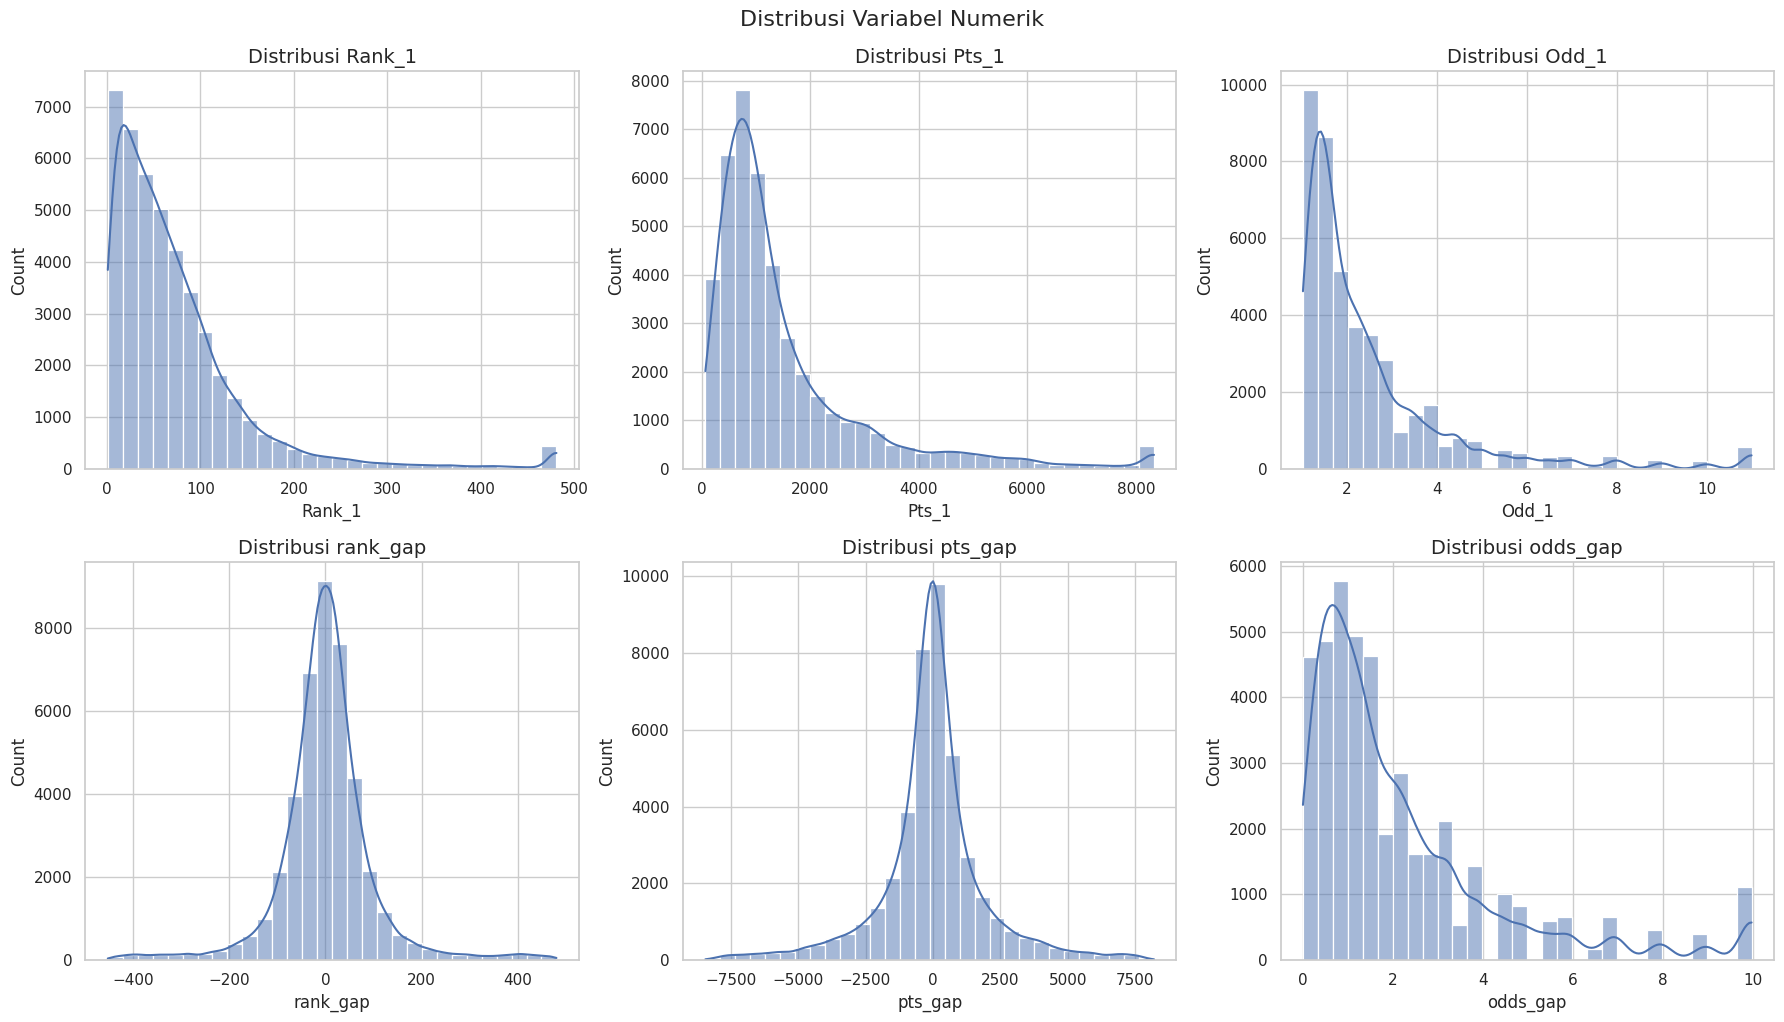

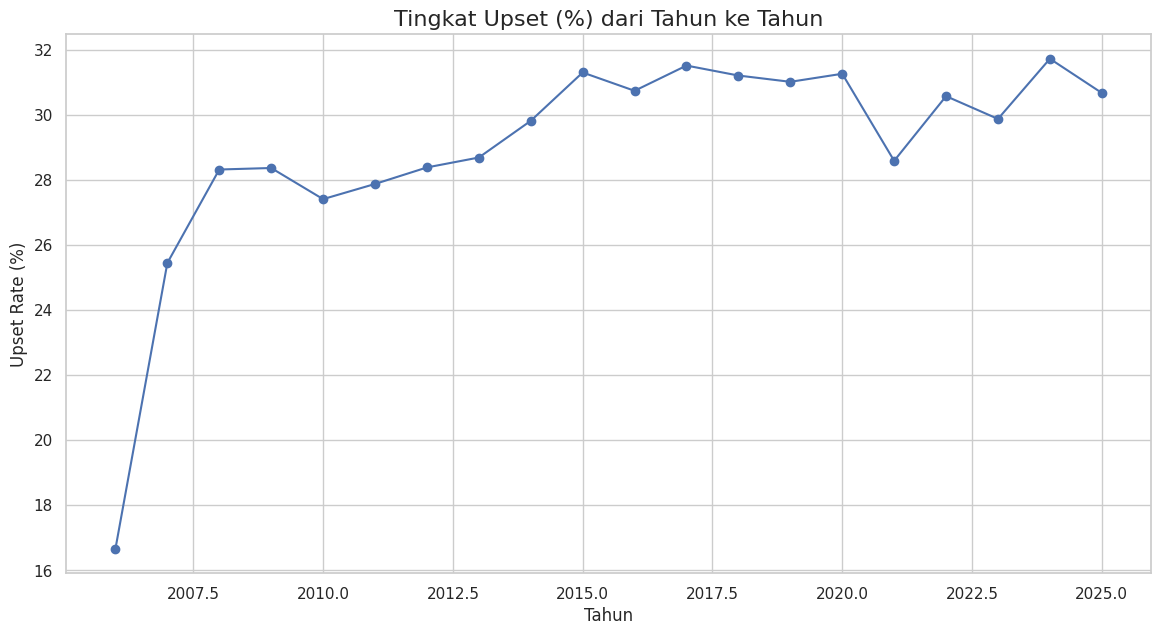

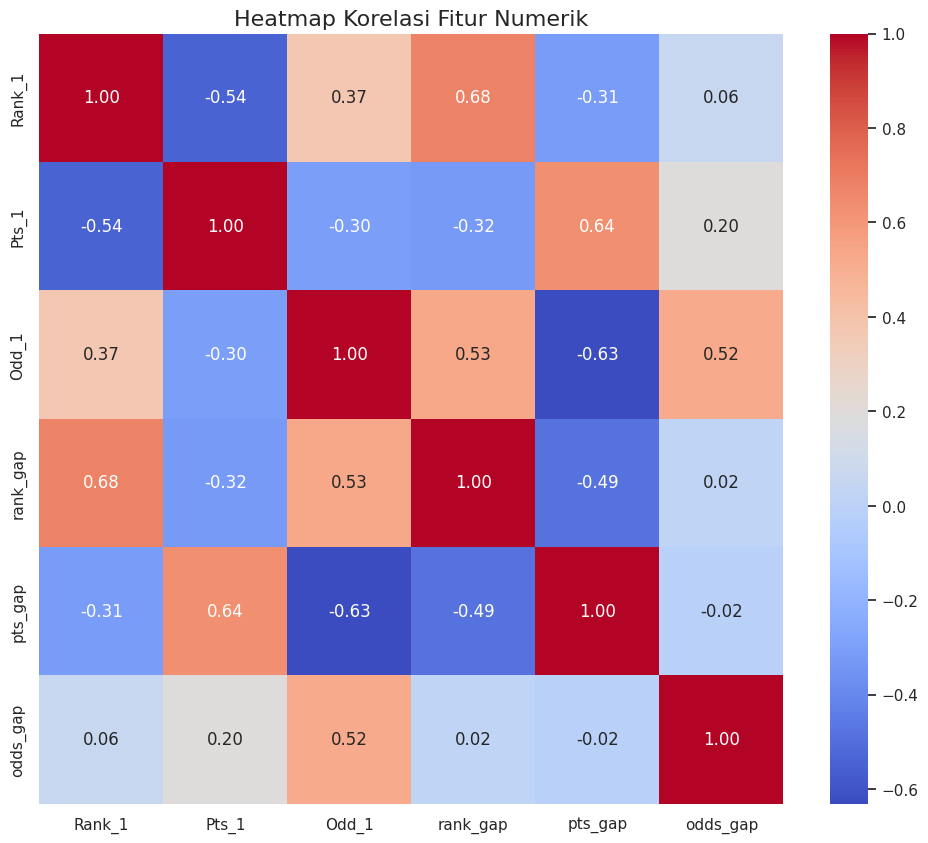

In [11]:
# --- 5.1. Distribusi Variabel Numerik Utama ---
numeric_features = ['Rank_1', 'Pts_1', 'Odd_1', 'rank_gap', 'pts_gap', 'odds_gap']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(df_clean[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribusi {col}', fontsize=14)

plt.tight_layout()
plt.suptitle('Distribusi Variabel Numerik', y=1.02, fontsize=16)
plt.show()


# --- 5.2. Analisis Upset per Tahun ---
if 'year' in df_clean.columns and 'upset' in df_clean.columns:
    upset_rate_per_year = df_clean.groupby('year')['upset'].mean() * 100

    plt.figure(figsize=(14, 7))
    ax = upset_rate_per_year.plot(kind='line', marker='o')
    ax.set_title('Tingkat Upset (%) dari Tahun ke Tahun', fontsize=16)
    ax.set_ylabel('Upset Rate (%)')
    ax.set_xlabel('Tahun')
    plt.show()

# --- 5.3. Korelasi antar Fitur ---
plt.figure(figsize=(12, 10))
corr_matrix = df_clean[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Fitur Numerik', fontsize=16)
plt.show()

## Perubahan Utama:

Plotting Dinamis: Kode untuk membuat histogram kini lebih ringkas, menggunakan subplots dan flatten untuk mengotomatisasi penempatan plot.

Analisis Baru: Saya tambahkan contoh plot baru, yaitu Tingkat Upset dari Tahun ke Tahun, yang bisa memberikan insight menarik (mirip dengan yang ada di dashboard Anda). Ini menunjukkan bagaimana kita bisa langsung mengeksplorasi fitur baru yang kita buat.

Heatmap: Dibuat lebih fokus pada fitur-fitur numerik yang relevan.

# Simpan Data yang Sudah Bersih

In [10]:
# Simpan DataFrame yang sudah bersih dan kaya fitur ke file CSV baru
df_clean.to_csv('wta_processed.csv', index=False)

print("Data yang sudah diproses disimpan sebagai 'wta_processed.csv'")

Data yang sudah diproses disimpan sebagai 'wta_processed.csv'
